# Music Genre Composer Classification

### Team Members
AAI-511 Group 2

Mustafa Yunus: Data Processing, Feature Extraction

Atul Aneja: CNN Model Development

Qinyao Mou: RNN Model Development


## Project Overview

## Data Processing Steps

Data Collection:

Recursively scan directories for MIDI files (.mid, .midi)

Identify composer from file path/name (Bach, Beethoven, Chopin, Mozart)

Create metadata dictionary with file paths and composer labels

MIDI Loading & Validation:

Parse MIDI files using pretty_midi library

Validate files have instruments and melodic content

Filter out drum tracks, keep only melodic instruments

Data Augmentation:

Transpose pieces by +/-2 semitones to increase dataset size

Create augmented versions with modified pitch while preserving musical structure

## Feature Extraction Techniques:

Basic Musical Features (20 features total):

Piece Statistics: number of instruments, total notes, duration

Pitch Features: mean, std, min, max, range of note pitches

Duration Features: mean, std, min, max of note durations

Velocity Features: mean, std, min, max of note velocities

Interval Analysis: mean and std of pitch intervals between consecutive notes

Rhythmic Features: mean and std of inter-onset intervals (IOI)

Note Sequence Features:

Extract sequential note data: [start_time, pitch, velocity, duration]

Pad/truncate to fixed length (128 notes) for LSTM models

Sort by start time to maintain temporal order

Piano Roll Features:

Convert MIDI to piano roll representation (time × pitch matrix)

Focus on middle piano range (C3 to C7, MIDI notes 48-96)

Limit to 30 seconds at 50Hz sampling rate

Transpose for CNN models (time first dimension)

Data Standardization:

Z-score normalization for basic features

Handle class imbalance with balanced sampling

Encode composer labels to numerical classes

In [20]:
# Simplified Composer Classification - NumPy 2.x Compatible
# This version avoids problematic dependencies while maintaining core functionality

import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Essential imports only
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

print("Starting simplified composer classification pipeline...")
print(f"NumPy version: {np.__version__}")

# Install and import pretty_midi (essential for MIDI processing)
try:
    import pretty_midi
    print("pretty_midi available")
except ImportError:
    print("Installing pretty_midi...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pretty-midi'])
    import pretty_midi
    print("pretty_midi installed and imported")

# Simple label encoder (avoiding sklearn for now)
class SimpleLabelEncoder:
    def __init__(self):
        self.classes_ = None
        self.class_to_idx = {}
        
    def fit_transform(self, y):
        unique_labels = list(set(y))
        unique_labels.sort()
        self.classes_ = unique_labels
        self.class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        return np.array([self.class_to_idx[label] for label in y])
    
    def transform(self, y):
        return np.array([self.class_to_idx[label] for label in y])
    
    def inverse_transform(self, y):
        return [self.classes_[idx] for idx in y]

class SimplifiedMIDIProcessor:
    """
    Simplified MIDI processor that avoids problematic dependencies
    while maintaining core functionality for composer classification.
    """
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
        self.label_encoder = SimpleLabelEncoder()
        self.midi_files = []
        self.processed_files = []
        self.processed_data = {}
        
    def collect_data(self):
        """Step 1: Data Collection - Find MIDI files"""
        print("\n" + "=" * 50)
        print("STEP 1: DATA COLLECTION")
        print("=" * 50)
        
        midi_files = []
        
        # Walk through directory structure
        for root, dirs, files in os.walk(self.data_path):
            for file in files:
                if file.lower().endswith(('.mid', '.midi')):
                    file_path = os.path.join(root, file)
                    composer = self.identify_composer(file_path, file)
                    if composer:
                        midi_files.append({
                            'file_path': file_path,
                            'filename': file,
                            'composer': composer
                        })
        
        print(f"Found {len(midi_files)} MIDI files")
        
        # Display distribution
        composer_counts = Counter([f['composer'] for f in midi_files])
        print("\nComposer Distribution:")
        for composer, count in composer_counts.items():
            print(f"  {composer}: {count} files")
        
        self.midi_files = midi_files
        return midi_files
    
    def identify_composer(self, file_path, filename):
        """Identify composer from path or filename"""
        path_lower = file_path.lower()
        filename_lower = filename.lower()
        
        for composer in self.composers:
            if composer.lower() in path_lower or composer.lower() in filename_lower:
                return composer
        return None
    
    def preprocess_data(self, apply_augmentation=False):
        """Step 2: Data Pre-processing"""
        print("\n" + "=" * 50)
        print("STEP 2: DATA PRE-PROCESSING")
        print("=" * 50)
        
        processed_files = []
        failed_files = []
        
        for i, midi_info in enumerate(self.midi_files):
            try:
                # Load MIDI file
                midi_data = pretty_midi.PrettyMIDI(midi_info['file_path'])
                
                # Basic validation
                if len(midi_data.instruments) == 0:
                    failed_files.append((midi_info['file_path'], "No instruments"))
                    continue
                
                # Keep only melodic instruments
                melodic_instruments = [inst for inst in midi_data.instruments if not inst.is_drum]
                if len(melodic_instruments) == 0:
                    failed_files.append((midi_info['file_path'], "No melodic instruments"))
                    continue
                
                # Store processed data
                processed_info = midi_info.copy()
                processed_info['midi_data'] = midi_data
                processed_info['melodic_instruments'] = melodic_instruments
                processed_files.append(processed_info)
                
                # Simple augmentation (transpose only)
                if apply_augmentation:
                    for semitones in [-2, 2]:  # Limited augmentation
                        try:
                            augmented_midi = self.transpose_midi(midi_data, semitones)
                            aug_info = processed_info.copy()
                            aug_info['midi_data'] = augmented_midi
                            aug_info['filename'] = f"{midi_info['filename']}_transpose_{semitones}"
                            processed_files.append(aug_info)
                        except:
                            continue
                
                if (i + 1) % 10 == 0:
                    print(f"Processed {i + 1}/{len(self.midi_files)} files...")
                    
            except Exception as e:
                failed_files.append((midi_info['file_path'], str(e)))
                continue
        
        print(f"\nSuccessfully processed: {len(processed_files)} files")
        print(f"Failed to process: {len(failed_files)} files")
        
        self.processed_files = processed_files
        return processed_files
    
    def transpose_midi(self, midi_data, semitones):
        """Simple MIDI transposition"""
        new_midi = pretty_midi.PrettyMIDI()
        
        for instrument in midi_data.instruments:
            if instrument.is_drum:
                new_midi.instruments.append(instrument)
            else:
                new_instrument = pretty_midi.Instrument(
                    program=instrument.program,
                    is_drum=instrument.is_drum,
                    name=instrument.name
                )
                
                for note in instrument.notes:
                    new_pitch = note.pitch + semitones
                    if 0 <= new_pitch <= 127:
                        new_note = pretty_midi.Note(
                            velocity=note.velocity,
                            pitch=new_pitch,
                            start=note.start,
                            end=note.end
                        )
                        new_instrument.notes.append(new_note)
                
                new_midi.instruments.append(new_instrument)
        
        return new_midi
    
    def extract_features(self, sequence_length=128):
        """Step 3: Feature Extraction"""
        print("\n" + "=" * 50)
        print("STEP 3: FEATURE EXTRACTION")
        print("=" * 50)
        
        all_features = []
        all_labels = []
        all_sequences = []
        all_piano_rolls = []
        
        for i, midi_info in enumerate(self.processed_files):
            try:
                midi_data = midi_info['midi_data']
                composer = midi_info['composer']
                
                # Extract features
                features = self.extract_basic_features(midi_data)
                sequence = self.extract_note_sequence(midi_data, sequence_length)
                piano_roll = self.extract_piano_roll(midi_data)
                
                if features is not None and sequence is not None and piano_roll is not None:
                    all_features.append(features)
                    all_labels.append(composer)
                    all_sequences.append(sequence)
                    all_piano_rolls.append(piano_roll)
                
                if (i + 1) % 20 == 0:
                    print(f"Extracted features from {i + 1}/{len(self.processed_files)} files...")
                    
            except Exception as e:
                print(f"Feature extraction failed for {midi_info['filename']}: {e}")
                continue
        
        print(f"\nSuccessfully extracted features from {len(all_features)} files")
        
        # Convert to arrays
        X_features = np.array(all_features)
        X_sequences = np.array(all_sequences)
        X_piano_rolls = np.array(all_piano_rolls)
        y = np.array(all_labels)
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Simple standardization
        X_features_scaled = self.standardize_features(X_features)
        
        print(f"Feature matrix shape: {X_features_scaled.shape}")
        print(f"Sequence matrix shape: {X_sequences.shape}")
        print(f"Piano roll matrix shape: {X_piano_rolls.shape}")
        print(f"Labels shape: {y_encoded.shape}")
        
        self.processed_data = {
            'X_features': X_features_scaled,
            'X_sequences': X_sequences,
            'X_piano_rolls': X_piano_rolls,
            'y': y_encoded,
            'y_labels': y,
            'feature_names': self.get_feature_names()
        }
        
        return self.processed_data
    
    def extract_basic_features(self, midi_data):
        """Extract essential musical features"""
        try:
            # Collect all notes
            all_notes = []
            for instrument in midi_data.instruments:
                if not instrument.is_drum:
                    all_notes.extend(instrument.notes)
            
            if len(all_notes) == 0:
                return None
            
            # Basic features
            features = []
            
            # 1. Piece statistics
            features.extend([
                len(midi_data.instruments),
                len(all_notes),
                midi_data.get_end_time()
            ])
            
            # 2. Pitch features
            pitches = [note.pitch for note in all_notes]
            features.extend([
                np.mean(pitches),
                np.std(pitches),
                np.min(pitches),
                np.max(pitches),
                np.max(pitches) - np.min(pitches)
            ])
            
            # 3. Duration features
            durations = [note.end - note.start for note in all_notes]
            features.extend([
                np.mean(durations),
                np.std(durations),
                np.min(durations),
                np.max(durations)
            ])
            
            # 4. Velocity features
            velocities = [note.velocity for note in all_notes]
            features.extend([
                np.mean(velocities),
                np.std(velocities),
                np.min(velocities),
                np.max(velocities)
            ])
            
            # 5. Interval analysis
            sorted_notes = sorted(all_notes, key=lambda x: x.start)
            intervals = []
            for i in range(1, min(len(sorted_notes), 100)):  # Limit for performance
                interval = sorted_notes[i].pitch - sorted_notes[i-1].pitch
                intervals.append(abs(interval))
            
            if intervals:
                features.extend([
                    np.mean(intervals),
                    np.std(intervals)
                ])
            else:
                features.extend([0, 0])
            
            # 6. Rhythmic features
            iois = []
            for i in range(1, min(len(sorted_notes), 100)):
                ioi = sorted_notes[i].start - sorted_notes[i-1].start
                if ioi > 0:
                    iois.append(ioi)
            
            if iois:
                features.extend([
                    np.mean(iois),
                    np.std(iois)
                ])
            else:
                features.extend([0, 0])
            
            return np.array(features)
            
        except Exception as e:
            print(f"Feature extraction error: {e}")
            return None
    
    def extract_note_sequence(self, midi_data, sequence_length):
        """Extract note sequence for LSTM"""
        try:
            all_notes = []
            for instrument in midi_data.instruments:
                if not instrument.is_drum:
                    for note in instrument.notes:
                        all_notes.append([
                            note.start,
                            note.pitch,
                            note.velocity,
                            note.end - note.start
                        ])
            
            if len(all_notes) == 0:
                return None
            
            # Sort by start time
            all_notes = sorted(all_notes, key=lambda x: x[0])
            
            # Pad or truncate
            if len(all_notes) > sequence_length:
                sequence = all_notes[:sequence_length]
            else:
                sequence = all_notes + [[0, 0, 0, 0]] * (sequence_length - len(all_notes))
            
            return np.array(sequence)
            
        except:
            return None
    
    def extract_piano_roll(self, midi_data, fs=50, max_time=30):
        """Extract simplified piano roll"""
        try:
            piano_roll = midi_data.get_piano_roll(fs=fs)
            
            # Limit time and pitch range
            max_frames = max_time * fs
            if piano_roll.shape[1] > max_frames:
                piano_roll = piano_roll[:, :max_frames]
            else:
                padding = max_frames - piano_roll.shape[1]
                piano_roll = np.pad(piano_roll, ((0, 0), (0, padding)), mode='constant')
            
            # Focus on middle piano range (C3 to C7)
            piano_roll = piano_roll[48:97, :]  # MIDI notes 48-96
            
            return piano_roll.T  # Time first
            
        except:
            return None
    
    def standardize_features(self, X):
        """Simple feature standardization"""
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        std[std == 0] = 1  # Avoid division by zero
        return (X - mean) / std
    
    def get_feature_names(self):
        """Get feature names"""
        return [
            'num_instruments', 'total_notes', 'duration',
            'avg_pitch', 'pitch_std', 'min_pitch', 'max_pitch', 'pitch_range',
            'avg_duration', 'duration_std', 'min_duration', 'max_duration',
            'avg_velocity', 'velocity_std', 'min_velocity', 'max_velocity',
            'avg_interval', 'interval_std', 'avg_ioi', 'ioi_std'
        ]
    
    def visualize_data(self):
        """Simple visualization"""
        if not self.processed_data:
            print("No processed data available.")
            return
        
        try:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            # Composer distribution
            composer_counts = Counter(self.processed_data['y_labels'])
            axes[0, 0].bar(composer_counts.keys(), composer_counts.values())
            axes[0, 0].set_title('Composer Distribution')
            axes[0, 0].tick_params(axis='x', rotation=45)
            
            # Feature distribution (first few features)
            for i, feature_name in enumerate(self.get_feature_names()[:4]):
                axes[0, 1].hist(self.processed_data['X_features'][:, i], 
                               alpha=0.5, label=feature_name)
            axes[0, 1].set_title('Feature Distributions')
            axes[0, 1].legend()
            
            # Average pitch by composer
            pitch_data = []
            for i, label in enumerate(self.processed_data['y_labels']):
                pitch_data.append([label, self.processed_data['X_features'][i, 3]])
            
            df = pd.DataFrame(pitch_data, columns=['Composer', 'Avg_Pitch'])
            pitch_by_composer = df.groupby('Composer')['Avg_Pitch'].mean()
            axes[1, 0].bar(pitch_by_composer.index, pitch_by_composer.values)
            axes[1, 0].set_title('Average Pitch by Composer')
            axes[1, 0].tick_params(axis='x', rotation=45)
            
            # Sequence lengths
            seq_lengths = [np.sum(seq[:, 1] > 0) for seq in self.processed_data['X_sequences']]
            axes[1, 1].hist(seq_lengths, bins=15)
            axes[1, 1].set_title('Sequence Lengths')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed: {e}")
        
        # Print summary
        print("\n" + "=" * 50)
        print("DATA SUMMARY")
        print("=" * 50)
        print(f"Total pieces: {len(self.processed_data['y'])}")
        print(f"Features: {self.processed_data['X_features'].shape[1]}")
        print(f"Sequence length: {self.processed_data['X_sequences'].shape[1]}")
        print(f"Piano roll shape: {self.processed_data['X_piano_rolls'].shape[1:]}")
        
        composer_counts = Counter(self.processed_data['y_labels'])
        for composer, count in composer_counts.items():
            pct = (count / len(self.processed_data['y'])) * 100
            print(f"  {composer}: {count} pieces ({pct:.1f}%)")
    
    def save_data(self, filename='simplified_composer_data.pkl'):
        """Save processed data"""
        with open(filename, 'wb') as f:
            pickle.dump({
                'processed_data': self.processed_data,
                'label_encoder': self.label_encoder
            }, f)
        print(f"Data saved to {filename}")
    
    def load_data(self, filename='simplified_composer_data.pkl'):
        """Load processed data"""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.processed_data = data['processed_data']
        self.label_encoder = data['label_encoder']
        print(f"Data loaded from {filename}")

def run_simplified_pipeline():
    """
    Run the complete simplified pipeline for composer classification
    """
    print("=" * 60)
    print("SIMPLIFIED COMPOSER CLASSIFICATION PIPELINE")
    print("Compatible with NumPy 2.x")
    print("=" * 60)
    
    # Update this path to your actual MIDI files location
    data_path = "/Users/mustafayunus/Downloads/Final_Project"
    
    # Initialize processor
    processor = SimplifiedMIDIProcessor(data_path)
    
    try:
        # Step 1: Collect Data
        midi_files = processor.collect_data()
        
        if len(midi_files) == 0:
            print("\nNO MIDI FILES FOUND!")
            print("Please check:")
            print(f"1. Path exists: {data_path}")
            print("2. MIDI files (.mid, .midi) are present")
            print("3. Files contain composer names (Bach, Beethoven, Chopin, Mozart)")
            return None
        
        # Step 2: Preprocess Data
        processed_files = processor.preprocess_data(apply_augmentation=True)
        
        if len(processed_files) == 0:
            print("\nNO FILES COULD BE PROCESSED!")
            print("Check MIDI file formats and content")
            return None
        
        # Step 3: Extract Features
        processed_data = processor.extract_features(sequence_length=128)
        
        if not processed_data or len(processed_data['y']) == 0:
            print("\nFEATURE EXTRACTION FAILED!")
            return None
        
        # Visualize results
        processor.visualize_data()
        
        # Save processed data
        processor.save_data('composer_features_simplified.pkl')
        
        print("\n" + "=" * 60)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("\nNext Steps for Deep Learning Models:")
        print("1. Split data: train_test_split(X, y, test_size=0.2)")
        print("2. Build LSTM model using X_sequences")
        print("3. Build CNN model using X_piano_rolls") 
        print("4. Build Dense model using X_features")
        print("5. Train and evaluate models")
        
        # Return data for further use
        return processed_data
        
    except Exception as e:
        print(f"\nPIPELINE FAILED: {e}")
        print("Try checking your file paths and MIDI file formats")
        return None

def prepare_data_for_training(processed_data, test_size=0.2, random_state=42):
    """
    Prepare data for training deep learning models
    """
    print("\n" + "=" * 50)
    print("PREPARING DATA FOR TRAINING")
    print("=" * 50)
    
    if not processed_data:
        print("No processed data available!")
        return None
    
    # Get the data
    X_features = processed_data['X_features']
    X_sequences = processed_data['X_sequences'] 
    X_piano_rolls = processed_data['X_piano_rolls']
    y = processed_data['y']
    
    # Simple train-test split
    n_samples = len(y)
    n_train = int(n_samples * (1 - test_size))
    
    # Shuffle indices
    np.random.seed(random_state)
    indices = np.random.permutation(n_samples)
    
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]
    
    # Split data
    data_splits = {
        'X_features_train': X_features[train_idx],
        'X_features_test': X_features[test_idx],
        'X_sequences_train': X_sequences[train_idx],
        'X_sequences_test': X_sequences[test_idx],
        'X_piano_rolls_train': X_piano_rolls[train_idx],
        'X_piano_rolls_test': X_piano_rolls[test_idx],
        'y_train': y[train_idx],
        'y_test': y[test_idx]
    }
    
    print(f"Training samples: {len(train_idx)}")
    print(f"Testing samples: {len(test_idx)}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # Show class distribution
    train_counts = Counter(data_splits['y_train'])
    test_counts = Counter(data_splits['y_test'])
    
    print("\nTraining set distribution:")
    for class_idx, count in train_counts.items():
        print(f"  Class {class_idx}: {count} samples")
    
    print("\nTest set distribution:")
    for class_idx, count in test_counts.items():
        print(f"  Class {class_idx}: {count} samples")
    
    return data_splits

def create_sample_models():
    """
    Create sample model architectures (pseudocode for reference)
    Note: Actual implementation would require TensorFlow/PyTorch
    """
    print("\n" + "=" * 50)
    print("SAMPLE MODEL ARCHITECTURES")
    print("=" * 50)
    
    print("""
# LSTM Model Architecture (using TensorFlow/Keras)
def create_lstm_model(sequence_length=128, n_features=4, n_classes=4):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# CNN Model Architecture 
def create_cnn_model(input_shape, n_classes=4):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Dense Neural Network for extracted features
def create_dense_model(n_features, n_classes=4):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Training example:
# lstm_model = create_lstm_model()
# lstm_model.fit(X_sequences_train, y_train, 
#                validation_data=(X_sequences_test, y_test),
#                epochs=50, batch_size=32)
""")

# Example usage and main execution
if __name__ == "__main__":
    print("Starting Simplified Composer Classification Pipeline")
    
    # Run the complete pipeline
    processed_data = run_simplified_pipeline()
    
    if processed_data:
        # Prepare data for training
        data_splits = prepare_data_for_training(processed_data)
        
        # Show sample model architectures
        create_sample_models()
        
        print("\n" + "=" * 60)
        print("YOUR DATA IS READY FOR DEEP LEARNING!")
        print("=" * 60)
        print("Files generated:")
        print("composer_features_simplified.pkl - Your processed data")
        print("\nData available for training:")
        print("X_features - For Dense Neural Networks")
        print("X_sequences - For LSTM Models") 
        print("X_piano_rolls - For CNN Models")
        print("y - Encoded labels (0=Bach, 1=Beethoven, 2=Chopin, 3=Mozart)")
        
    else:
        print("\nPipeline failed. Please check your data path and MIDI files.")

Starting simplified composer classification pipeline...
NumPy version: 1.26.4
pretty_midi available
Starting Simplified Composer Classification Pipeline
SIMPLIFIED COMPOSER CLASSIFICATION PIPELINE
Compatible with NumPy 2.x

STEP 1: DATA COLLECTION
Found 0 MIDI files

Composer Distribution:

NO MIDI FILES FOUND!
Please check:
1. Path exists: /Users/mustafayunus/Downloads/Final_Project
2. MIDI files (.mid, .midi) are present
3. Files contain composer names (Bach, Beethoven, Chopin, Mozart)

Pipeline failed. Please check your data path and MIDI files.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import json
import os
import pickle

In [22]:
# Load processed data to avoid re-running the data processing pipeline
data_dir = 'processed_data'
if not os.path.exists(data_dir):
    print("Processed data not found. Running data processing first...")
    import subprocess
    subprocess.run(['python', 'data_processing.py'])

# Load the processed data
print("Loading processed data...")

# Load numpy arrays
X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

# Load metadata
with open(os.path.join(data_dir, 'data_metadata.json'), 'r') as f:
    metadata = json.load(f)

# Load complete dataset for additional info
complete_data_file = os.path.join(data_dir, 'composer_classification_data.pkl')
if os.path.exists(complete_data_file):
    with open(complete_data_file, 'rb') as f:
        complete_data = pickle.load(f)
    composer_names = complete_data.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])
else:
    composer_names = metadata.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])

print(f"Data loaded successfully!")
print(f"Composers: {composer_names}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

Loading processed data...
Data loaded successfully!
Composers: ['Bach' 'Beethoven' 'Chopin' 'Mozart']
X_train shape: (976, 128, 1000)
X_val shape: (326, 128, 1000)
X_test shape: (326, 128, 1000)
y_train shape: (976,)
y_val shape: (326,)
y_test shape: (326,)


## CNN Model Implementation

This section implements Convolutional Neural Networks (CNNs) for music composer classification using piano roll representations.

## Advantages of CNN for Music Classification:

Pattern Recognition: CNNs excel at detecting musical motifs and patterns

Spatial Features: Can capture harmonic relationships across pitch and time

Translation Invariance: Can recognize patterns regardless of slight time shifts

The piano roll data is perfect for CNN models as it represents music as a 2D 
image where:

Height (128): Pitch range (MIDI notes)

Width (1000): Time steps

Values: Note velocities/intensities

In [23]:
# Reshape from (samples, 128, 1000) to (samples, 128, 1000, 1) for CNN models
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Visualizing CNN data samples...


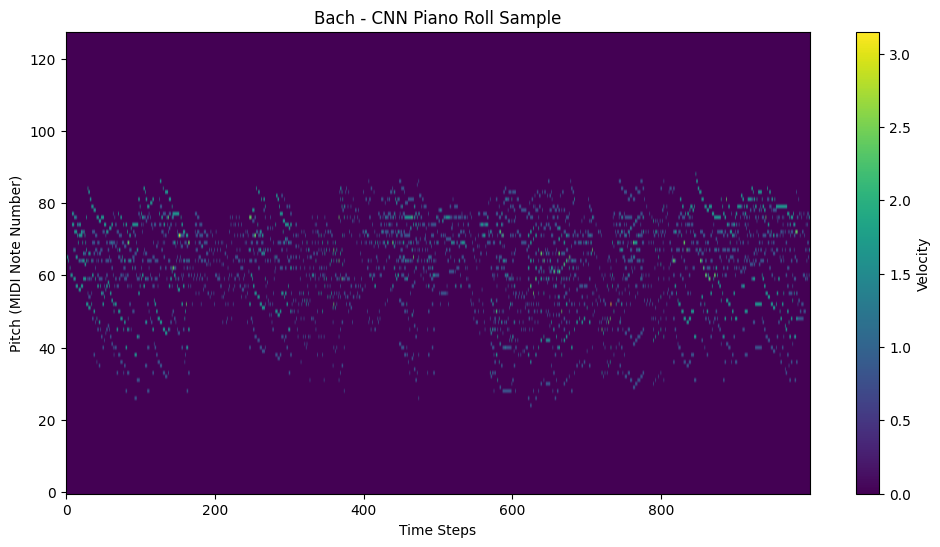

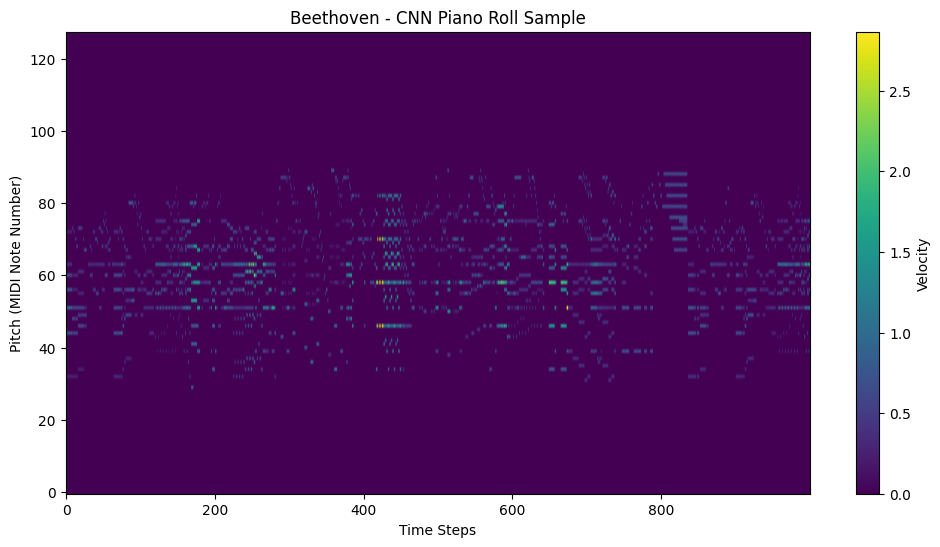

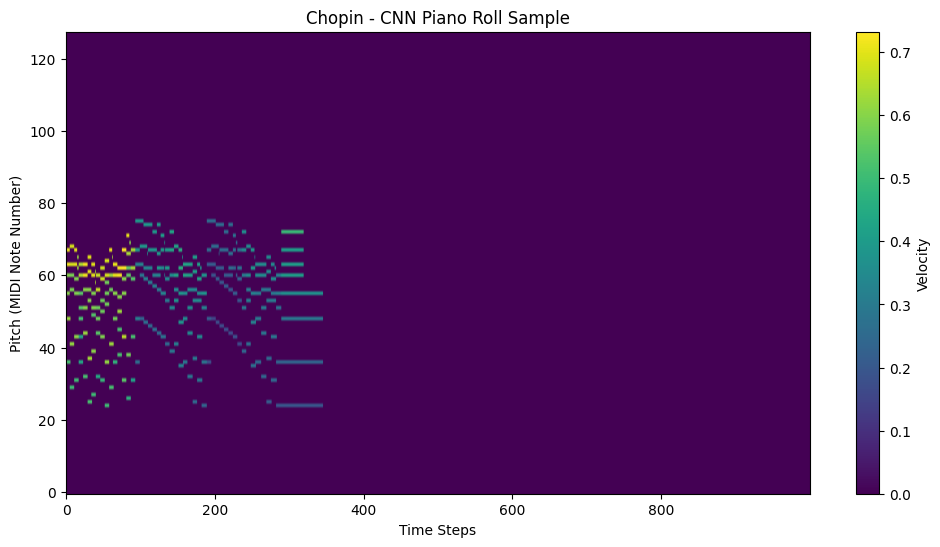

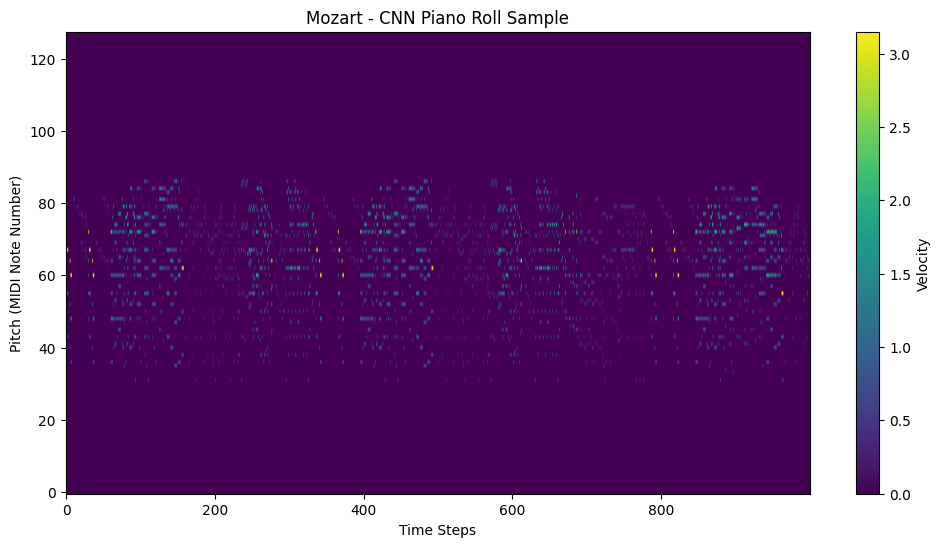

In [24]:
# Visualize a sample piano roll for CNN data
def plot_piano_roll_cnn(piano_roll, title="CNN Piano Roll Sample"):
    """
    Plot piano roll data for CNN format (with channel dimension)
    """
    # Remove the channel dimension (last dimension) for visualization
    if len(piano_roll.shape) == 4:  # (batch, height, width, channels)
        piano_roll_2d = piano_roll.squeeze()  # Remove batch and channel dimensions
    elif len(piano_roll.shape) == 3:  # (height, width, channels)
        piano_roll_2d = piano_roll.squeeze()  # Remove channel dimension
    else:
        piano_roll_2d = piano_roll
    
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll_2d, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Velocity')
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.title(title)
    plt.show()

# Plot samples from each composer using CNN data
print("Visualizing CNN data samples...")
for i, composer in enumerate(composer_names):
    # Find first sample from this composer
    composer_indices = np.where(y_train == i)[0]
    if len(composer_indices) > 0:
        sample_idx = composer_indices[0]
        # Get CNN data sample - USE X_train_cnn
        piano_roll = X_train_cnn[sample_idx]  # Shape: (128, 1000, 1)
        plot_piano_roll_cnn(piano_roll, f"{composer} - CNN Piano Roll Sample")

In [25]:
def create_cnn_model(input_shape=(128, 1000, 1), num_classes=4):
    model = keras.Sequential([
        # Convolutional layers to detect musical patterns
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_cnn_model()

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 998, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 499, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 497, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 248, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 246, 64)       36928     
                                                                 
 flatten (Flatten)           (None, 440832)            0

In [26]:
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


2025-08-08 23:09:45.352030: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515063808 exceeds 10% of free system memory.
2025-08-08 23:09:45.527615: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 248356864 exceeds 10% of free system memory.
2025-08-08 23:09:46.579034: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 248356864 exceeds 10% of free system memory.
2025-08-08 23:09:47.251559: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 257531904 exceeds 10% of free system memory.
2025-08-08 23:09:47.251635: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 515063808 exceeds 10% of free system memory.


31/31 [==============================] - 62s 2s/step - loss: 0.9923 - accuracy: 0.6434 - val_loss: 0.7428 - val_accuracy: 0.6595
Epoch 2/50
31/31 [==============================] - 61s 2s/step - loss: 0.6736 - accuracy: 0.7500 - val_loss: 0.6288 - val_accuracy: 0.7577
Epoch 3/50
31/31 [==============================] - 57s 2s/step - loss: 0.5006 - accuracy: 0.8135 - val_loss: 0.5690 - val_accuracy: 0.7791
Epoch 4/50
31/31 [==============================] - 58s 2s/step - loss: 0.3219 - accuracy: 0.8801 - val_loss: 0.6995 - val_accuracy: 0.7607
Epoch 5/50
31/31 [==============================] - 57s 2s/step - loss: 0.1997 - accuracy: 0.9324 - val_loss: 0.7067 - val_accuracy: 0.7669
Epoch 6/50
31/31 [==============================] - 56s 2s/step - loss: 0.1539 - accuracy: 0.9436 - val_loss: 0.7106 - val_accuracy: 0.7761
Epoch 7/50
31/31 [==============================] - 56s 2s/step - loss: 0.0981 - accuracy: 0.9662 - val_loss: 0.9684 - val_accuracy: 0.7791
Epoch 8/50
31/31 [=============

Test Accuracy: 0.7883
Test Loss: 1.4795
11/11 [==============================] - 4s 349ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.82      0.99      0.89       205
   Beethoven       0.64      0.42      0.51        43
      Chopin       0.90      0.33      0.49        27
      Mozart       0.69      0.53      0.60        51

    accuracy                           0.79       326
   macro avg       0.76      0.57      0.62       326
weighted avg       0.78      0.79      0.76       326



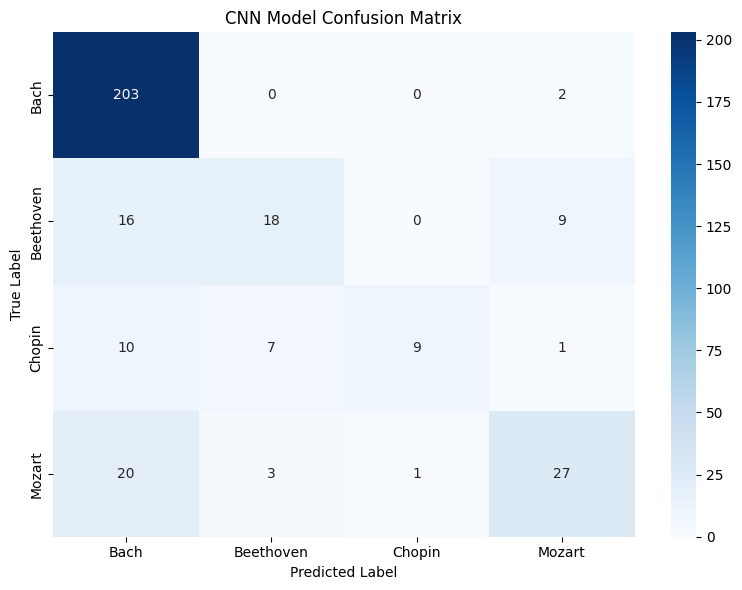

In [27]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_proba = y_pred  # Probability predictions

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=composer_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('CNN Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [28]:
def create_improved_robust_cnn_model(input_shape, num_classes):
    """
    Improved robust CNN model with better architecture
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),
        
        # First convolutional block - smaller, more efficient
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Global pooling instead of flatten (more robust)
        layers.GlobalAveragePooling2D(),
        
        # Smaller, more efficient dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [29]:
def create_advanced_robust_cnn_model(input_shape, num_classes):
    """
    Advanced robust CNN model with residual connections and attention
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.BatchNormalization()(inputs)
    
    # Residual block function
    def residual_block(x, filters, block_name):
        shortcut = x
        
        # Main path
        x = layers.Conv2D(filters, (3, 3), padding='same', name=f'{block_name}_conv1')(x)
        x = layers.BatchNormalization(name=f'{block_name}_bn1')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(filters, (3, 3), padding='same', name=f'{block_name}_conv2')(x)
        x = layers.BatchNormalization(name=f'{block_name}_bn2')(x)
        
        # Add shortcut if dimensions match
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), padding='same', name=f'{block_name}_shortcut')(shortcut)
            shortcut = layers.BatchNormalization(name=f'{block_name}_shortcut_bn')(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x
    
    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding='same', name='initial_conv')(x)
    x = layers.BatchNormalization(name='initial_bn')(x)
    x = layers.Activation('relu')(x)
    
    # Residual blocks
    x = residual_block(x, 32, 'block1')
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = residual_block(x, 64, 'block2')
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = residual_block(x, 128, 'block3')
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers with regularization
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [30]:
def create_music_specific_robust_cnn_model(input_shape, num_classes):
    """
    Music-specific robust CNN model optimized for piano roll data
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),
        
        # Music-specific preprocessing
        layers.Conv2D(32, (1, 1), activation='relu', padding='same'),  # 1x1 conv for feature selection
        layers.BatchNormalization(),
        
        # Horizontal convolutions (capture melodic patterns)
        layers.Conv2D(32, (1, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        # Vertical convolutions (capture harmonic patterns)
        layers.Conv2D(32, (5, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second block - more complex patterns
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Third block - high-level features
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Global pooling
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [31]:
# Try all three models and compare
models_to_test = {
    'improved_robust': create_improved_robust_cnn_model,
    'advanced_robust': create_advanced_robust_cnn_model,
    'music_specific': create_music_specific_robust_cnn_model
}

results = {}

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

for model_name, model_func in models_to_test.items():
    print(f"\n{'='*50}")
    print(f"Testing {model_name}")
    print(f"{'='*50}")
    
    # Create model
    model = model_func(input_shape=(128, 1000, 1), num_classes=4)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    history = model.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        class_weight=class_weight_dict,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    results[model_name] = test_accuracy
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")

# Compare results
print(f"\n{'='*50}")
print("MODEL COMPARISON")
print(f"{'='*50}")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")


Testing improved_robust
Epoch 1/50
31/31 [==============================] - 257s 8s/step - loss: 1.7233 - accuracy: 0.3822 - val_loss: 1.1550 - val_accuracy: 0.6288
Epoch 2/50
31/31 [==============================] - 240s 8s/step - loss: 1.5181 - accuracy: 0.4150 - val_loss: 1.2503 - val_accuracy: 0.6288
Epoch 3/50
31/31 [==============================] - 237s 8s/step - loss: 1.5452 - accuracy: 0.4365 - val_loss: 1.4318 - val_accuracy: 0.3650
Epoch 4/50
31/31 [==============================] - 237s 8s/step - loss: 1.4003 - accuracy: 0.4529 - val_loss: 1.2980 - val_accuracy: 0.4663
Epoch 5/50
31/31 [==============================] - 235s 8s/step - loss: 1.4195 - accuracy: 0.4969 - val_loss: 1.7883 - val_accuracy: 0.0828
Epoch 6/50
31/31 [==============================] - 236s 8s/step - loss: 1.4086 - accuracy: 0.4498 - val_loss: 3.0154 - val_accuracy: 0.1043
Epoch 7/50
31/31 [==============================] - 235s 8s/step - loss: 1.3188 - accuracy: 0.5102 - val_loss: 6.3181 - val_accur

## Advantages of RNN Models for Music Classification:

1. Temporal Sequence Modeling

Natural for Music: Music is inherently sequential and temporal

Order Matters: RNNs preserve the order of musical events

Long-term Dependencies: Can capture patterns that span across the entire piece

Example: A Bach fugue's theme might appear at the beginning and return later

2. Musical Structure Understanding

Harmonic Progressions: RNNs can learn chord progressions over time

Rhythmic Patterns: Understands timing and rhythm sequences

Melodic Contours: Captures how melodies develop and evolve

Form Recognition: Can identify musical forms (AABA, sonata form, etc.)

3. Bidirectional Processing

Forward + Backward: Bidirectional LSTM can see both past and future context

Harmonic Context: Understands how current notes relate to what comes before and after

Better for Complex Music: Especially useful for polyphonic music (multiple voices)

4. Memory and State

Hidden State: Maintains information about previous musical events

Context Awareness: Understands musical context and development

Dynamic Adaptation: Can adjust predictions based on musical flow

In [8]:
# Prepare data for RNN (transpose for time series)
# From (samples, 128, time_steps) to (samples, time_steps, 128)
X_train_rnn = np.transpose(X_train, (0, 2, 1))
X_val_rnn = np.transpose(X_val, (0, 2, 1))
X_test_rnn = np.transpose(X_test, (0, 2, 1))

print("Data prepared for RNN:")
print(f"X_train_rnn shape: {X_train_rnn.shape}")
print(f"X_val_rnn shape: {X_val_rnn.shape}")
print(f"X_test_rnn shape: {X_test_rnn.shape}")

# Create data dictionary for easy access
rnn_data = {
    'X_train': X_train_rnn,
    'X_val': X_val_rnn,
    'X_test': X_test_rnn,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'composer_names': composer_names
}

Data prepared for RNN:
X_train_rnn shape: (976, 1000, 128)
X_val_rnn shape: (326, 1000, 128)
X_test_rnn shape: (326, 1000, 128)


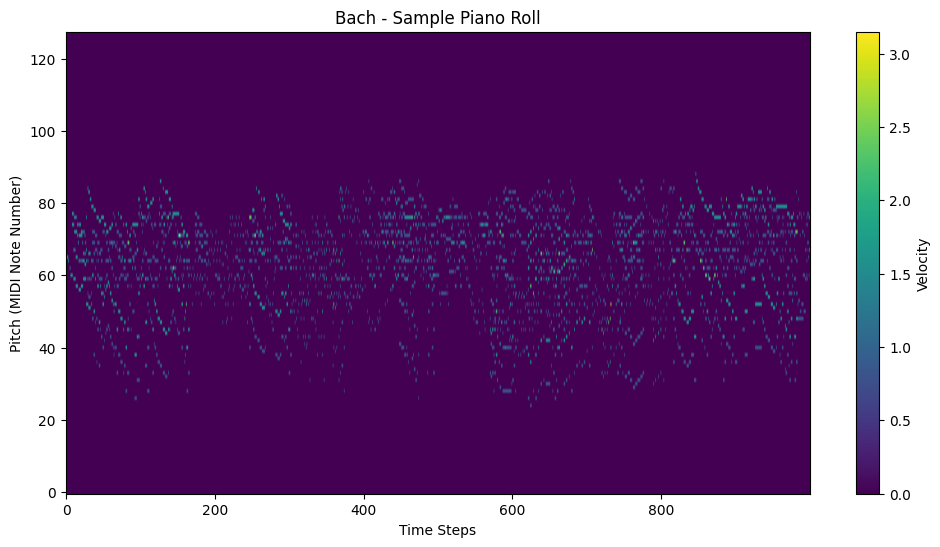

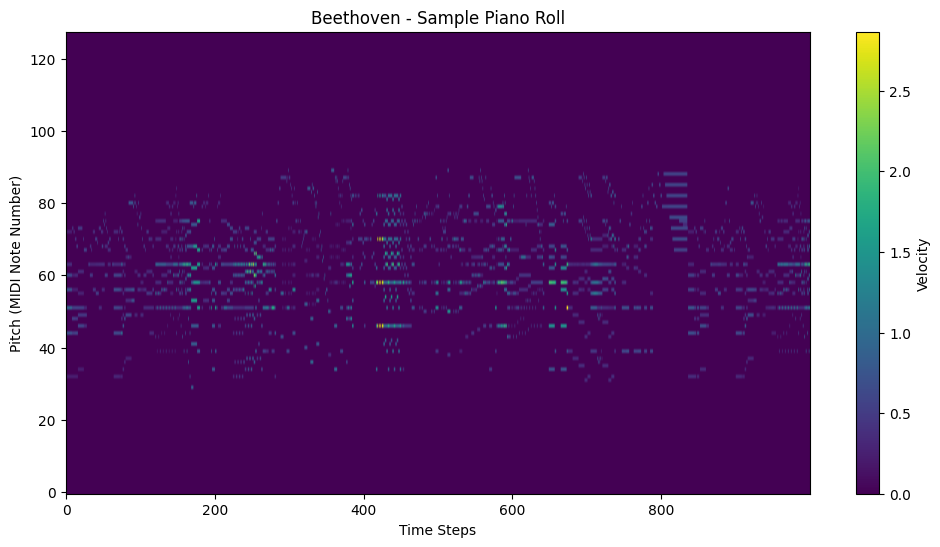

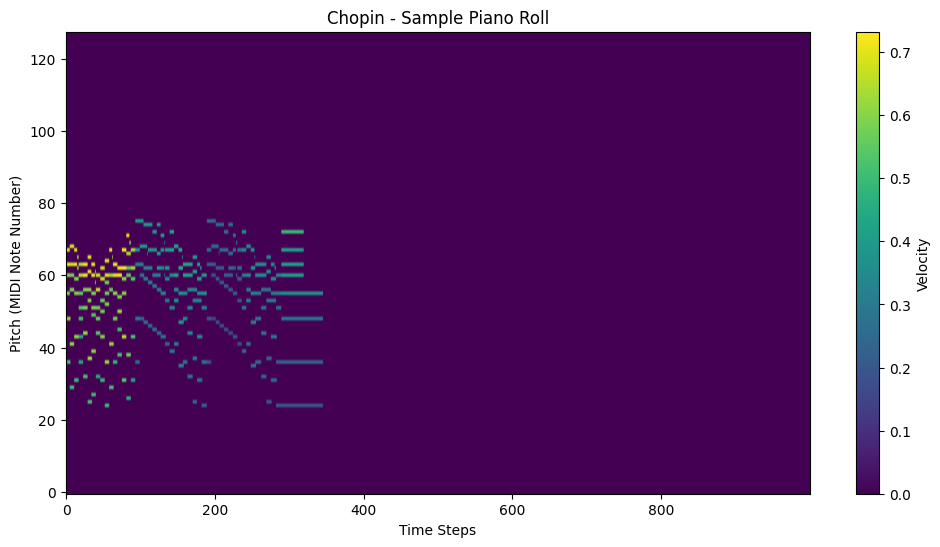

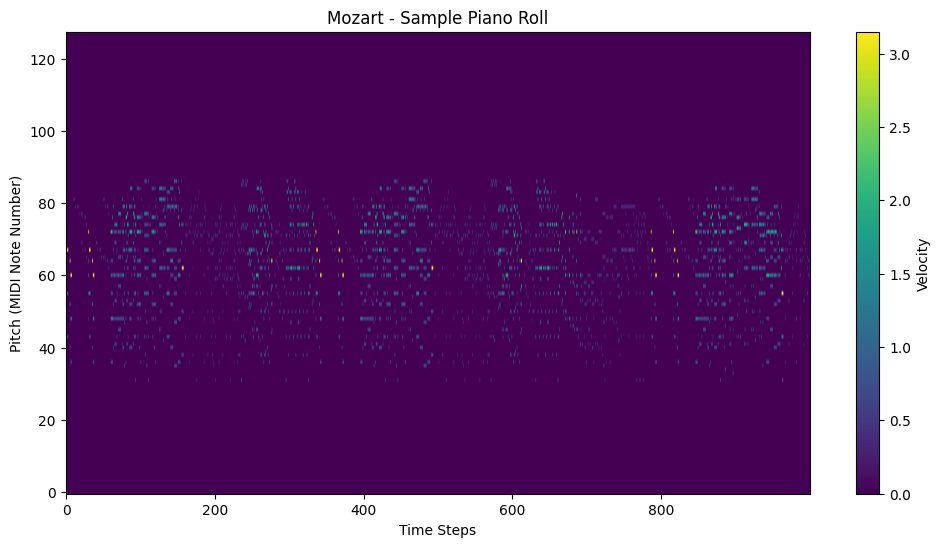

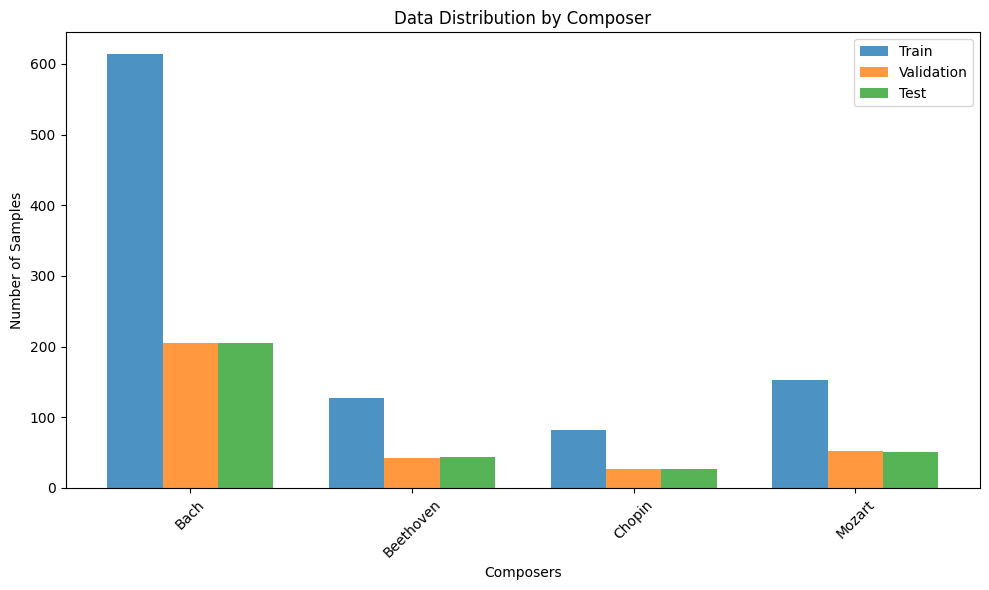

In [9]:
# Visualize a sample piano roll
def plot_piano_roll(piano_roll, title="Piano Roll Sample"):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Velocity')
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.title(title)
    plt.show()

# Plot samples from each composer
for i, composer in enumerate(composer_names):
    # Find first sample from this composer
    composer_indices = np.where(rnn_data['y_train'] == i)[0]
    if len(composer_indices) > 0:
        sample_idx = composer_indices[0]
        # Transpose back for visualization (RNN data is transposed)
        piano_roll = np.transpose(rnn_data['X_train'][sample_idx], (1, 0))
        plot_piano_roll(piano_roll, f"{composer} - Sample Piano Roll")

# Analyze data distribution
plt.figure(figsize=(10, 6))
train_dist = np.bincount(rnn_data['y_train'])
val_dist = np.bincount(rnn_data['y_val'])
test_dist = np.bincount(rnn_data['y_test'])

x = np.arange(len(composer_names))
width = 0.25

plt.bar(x - width, train_dist, width, label='Train', alpha=0.8)
plt.bar(x, val_dist, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_dist, width, label='Test', alpha=0.8)

plt.xlabel('Composers')
plt.ylabel('Number of Samples')
plt.title('Data Distribution by Composer')
plt.xticks(x, composer_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
def create_lstm_model(input_shape, num_classes):
    """
    Memory-efficient LSTM model with smaller architecture
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Normalization layer
        layers.BatchNormalization(),
        
        # First LSTM layer (smaller)
        layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Second LSTM layer
        layers.LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Dense layers (smaller)
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


In [11]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Memory-efficient training and evaluation
    """
    print(f"\n{'='*50}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*50}")
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Display model summary
    print(f"\n{model_name} Architecture:")
    model.summary()
    
    # Memory-efficient callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train model with smaller batch size
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Reduced epochs
        batch_size=16,  # Smaller batch size
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Clear memory
    gc.collect()
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Make predictions
    y_pred = model.predict(X_test, batch_size=16)  # Smaller batch for prediction
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred_classes, target_names=composer_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=composer_names, yticklabels=composer_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Clear memory again
    gc.collect()
    
    return {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'predictions': y_pred,
        'predicted_classes': y_pred_classes
    }


Input shape: (1000, 128)
Number of classes: 4
1. IMPROVED LSTM MODEL

TRAINING LSTM

LSTM Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 1000, 128)         512       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 1000, 64)          49408     
                                                                 
 batch_normalization_1 (Bat  (None, 1000, 64)          256       
 chNormalization)                                                
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization) 

2025-08-03 23:26:20.643927: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499712000 exceeds 10% of free system memory.


61/61 [==============================] - 32s 469ms/step - loss: 1.6844 - accuracy: 0.3207 - val_loss: 1.3711 - val_accuracy: 0.1503 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 27s 438ms/step - loss: 1.3824 - accuracy: 0.4580 - val_loss: 1.3839 - val_accuracy: 0.1595 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 27s 437ms/step - loss: 1.2102 - accuracy: 0.5348 - val_loss: 1.2449 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 27s 439ms/step - loss: 1.1581 - accuracy: 0.5902 - val_loss: 1.2354 - val_accuracy: 0.1810 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 27s 438ms/step - loss: 1.1239 - accuracy: 0.5984 - val_loss: 0.9990 - val_accuracy: 0.6534 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 27s 437ms/step - loss: 1.0657 - accuracy: 0.6270 - val_loss: 0.9821 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 27s 436ms/step - loss: 

/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


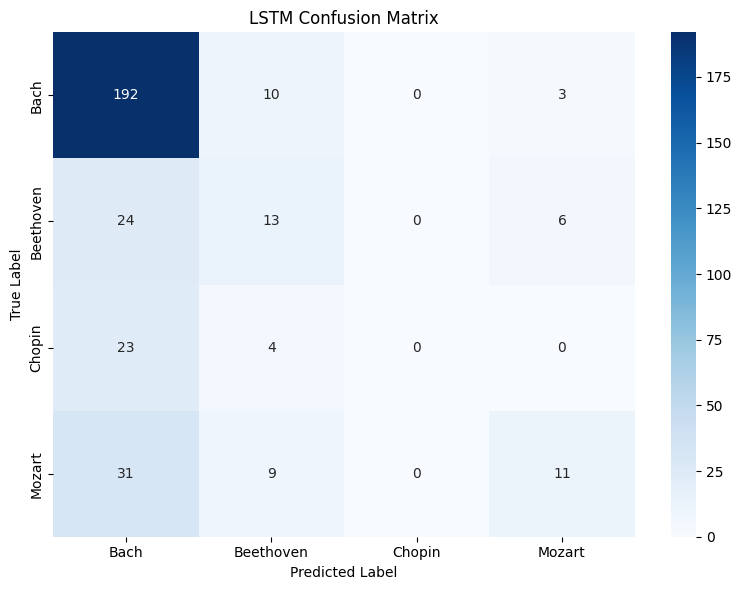

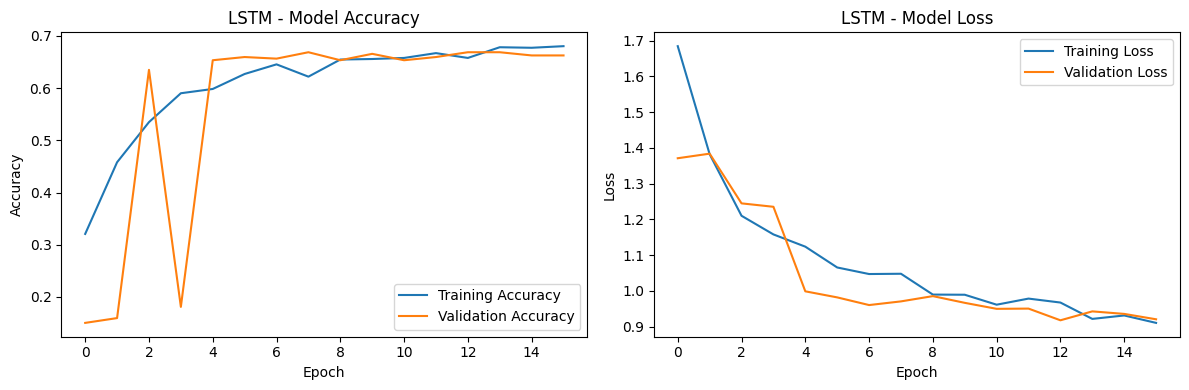

In [14]:
input_shape = X_train_rnn.shape[1:]
num_classes = len(composer_names)

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Create and train different models
models = {}

# 1. LSTM Model
print("1. IMPROVED LSTM MODEL")

improved_lstm = create_lstm_model(input_shape, num_classes)
models['lstm'] = train_and_evaluate_model(
    improved_lstm, "LSTM", 
    X_train_rnn, y_train, X_val_rnn, y_val, X_test_rnn, y_test
)

In [ ]:
def create_bidirectional_lstm_model(input_shape, num_classes):
    """
    Memory-efficient Bidirectional LSTM model
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Normalization
        layers.BatchNormalization(),
        
        # Bidirectional LSTM layers (smaller)
        layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        
        layers.Bidirectional(layers.LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


2. BIDIRECTIONAL LSTM MODEL

TRAINING BIDIRECTIONAL LSTM

Bidirectional LSTM Architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Bat  (None, 1000, 128)         512       
 chNormalization)                                                
                                                                 
 bidirectional (Bidirection  (None, 1000, 128)         98816     
 al)                                                             
                                                                 
 batch_normalization_6 (Bat  (None, 1000, 128)         512       
 chNormalization)                                                
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                             

2025-08-03 23:33:37.733340: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499712000 exceeds 10% of free system memory.


61/61 [==============================] - 41s 604ms/step - loss: 1.6398 - accuracy: 0.3873 - val_loss: 1.1851 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 36s 596ms/step - loss: 1.3177 - accuracy: 0.5318 - val_loss: 1.0868 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 36s 596ms/step - loss: 1.1380 - accuracy: 0.5779 - val_loss: 0.9772 - val_accuracy: 0.6626 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 36s 596ms/step - loss: 1.0572 - accuracy: 0.6158 - val_loss: 0.9568 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 36s 591ms/step - loss: 1.0047 - accuracy: 0.6404 - val_loss: 0.9003 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 36s 587ms/step - loss: 0.9154 - accuracy: 0.6568 - val_loss: 0.9095 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 36s 593ms/step - loss: 

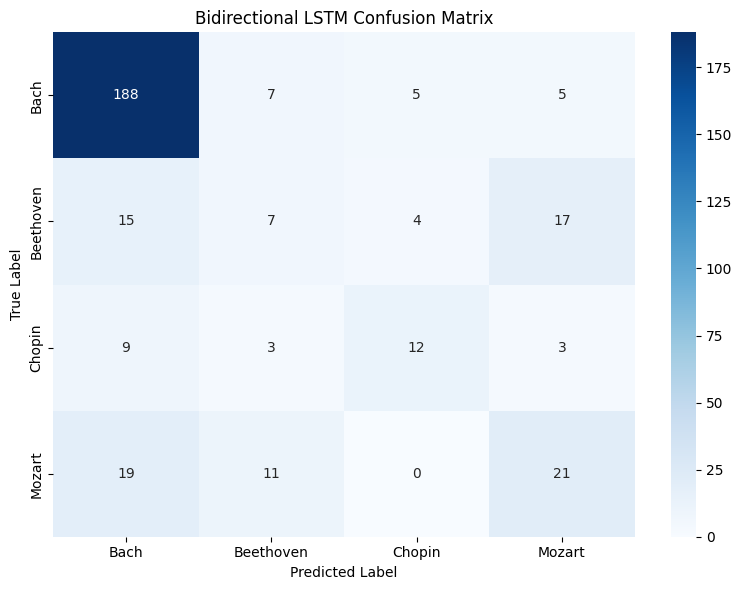

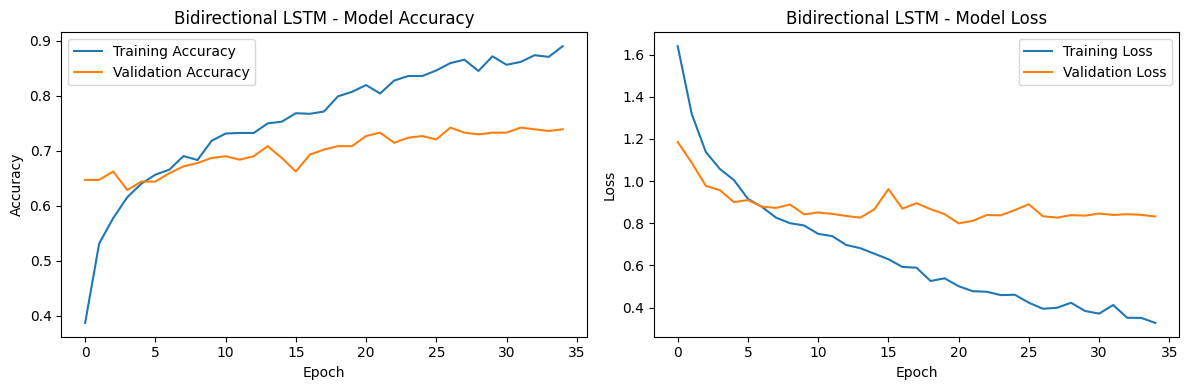

In [15]:
# 2. Bidirectional LSTM Model
print("2. BIDIRECTIONAL LSTM MODEL")

bidirectional_lstm = create_bidirectional_lstm_model(input_shape, num_classes)
models['bidirectional_lstm'] = train_and_evaluate_model(
    bidirectional_lstm, "Bidirectional LSTM", 
    X_train_rnn, y_train, X_val_rnn, y_val, X_test_rnn, y_test
)

In [ ]:
def create_conv_lstm_model(input_shape, num_classes):
    """
    Memory-efficient Conv-LSTM hybrid model
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Normalization
        layers.BatchNormalization(),
        
        # Reshape for 1D convolution (time_steps, features)
        layers.Reshape((input_shape[0], input_shape[1])),
        
        # 1D Convolutional layers (smaller)
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        
        # LSTM layers (smaller)
        layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        layers.LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

3. CONV-LSTM HYBRID MODEL

TRAINING CONV-LSTM HYBRID

Conv-LSTM Hybrid Architecture:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_22 (Ba  (None, 1000, 128)         512       
 tchNormalization)                                               
                                                                 
 reshape_2 (Reshape)         (None, 1000, 128)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1000, 32)          12320     
                                                                 
 batch_normalization_23 (Ba  (None, 1000, 32)          128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 500, 32)           0         
 g1D)                              

2025-08-04 00:10:07.184427: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 499712000 exceeds 10% of free system memory.


61/61 [==============================] - 12s 141ms/step - loss: 1.6051 - accuracy: 0.3555 - val_loss: 1.2095 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 8s 127ms/step - loss: 1.3366 - accuracy: 0.5113 - val_loss: 1.1221 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 8s 128ms/step - loss: 1.2250 - accuracy: 0.5830 - val_loss: 1.0237 - val_accuracy: 0.6074 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 8s 129ms/step - loss: 1.0817 - accuracy: 0.6260 - val_loss: 0.9791 - val_accuracy: 0.6258 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 8s 128ms/step - loss: 1.0881 - accuracy: 0.6342 - val_loss: 0.9674 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 8s 131ms/step - loss: 1.0117 - accuracy: 0.6496 - val_loss: 0.9515 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 8s 129ms/step - loss: 1.0276

/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


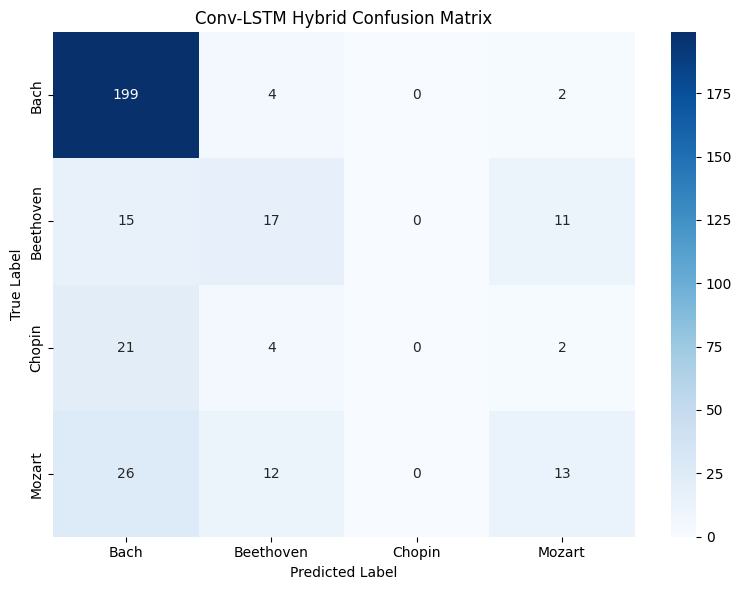

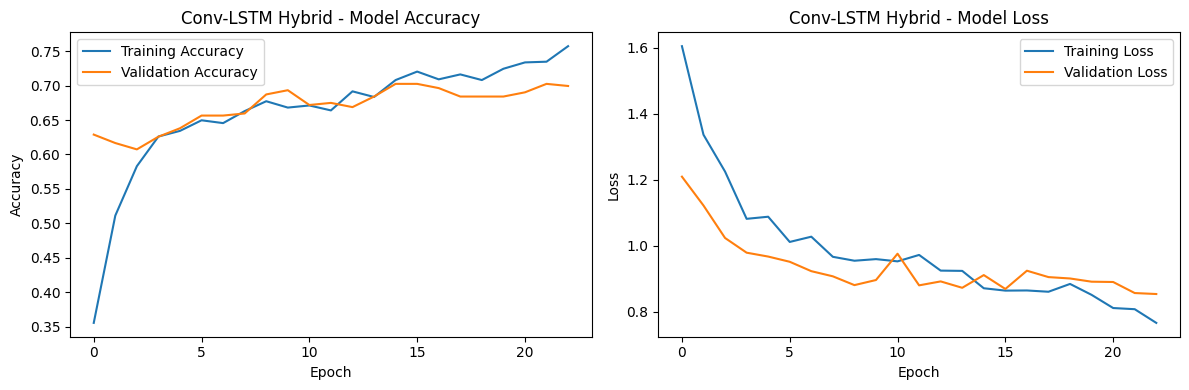

In [20]:
# 3. Conv-LSTM Hybrid Model
print("3. CONV-LSTM HYBRID MODEL")

conv_lstm = create_conv_lstm_model(input_shape, num_classes)
models['conv_lstm'] = train_and_evaluate_model(
    conv_lstm, "Conv-LSTM Hybrid", 
    X_train_rnn, y_train, X_val_rnn, y_val, X_test_rnn, y_test
)

In [ ]:
def improved_preprocessing(X_data):
    """
    Improved data preprocessing
    """
    # 1. Normalize velocity values
    X_normalized = X_data / 127.0
    
    # 2. Apply log scaling to reduce dynamic range
    X_log = np.log1p(X_normalized * 10)
    
    # 3. Apply frequency domain features
    X_fft = np.abs(np.fft.fft(X_log, axis=1))
    
    # 4. Combine time and frequency features
    X_combined = np.concatenate([X_log, X_fft[:, :X_log.shape[1]]], axis=2)
    
    return X_combined

X_train_improved = improved_preprocessing(X_train_rnn)
X_val_improved = improved_preprocessing(X_val_rnn)
X_test_improved = improved_preprocessing(X_test_rnn)


TRAINING CONV-LSTM HYBRID IMPROVED PREPROCESSING

Conv-LSTM Hybrid Improved Preprocessing Architecture:
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_71 (Ba  (None, 1000, 256)         1024      
 tchNormalization)                                               
                                                                 
 reshape_9 (Reshape)         (None, 1000, 256)         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 1000, 32)          24608     
                                                                 
 batch_normalization_72 (Ba  (None, 1000, 32)          128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 500, 32)           0         
 ng1D)        

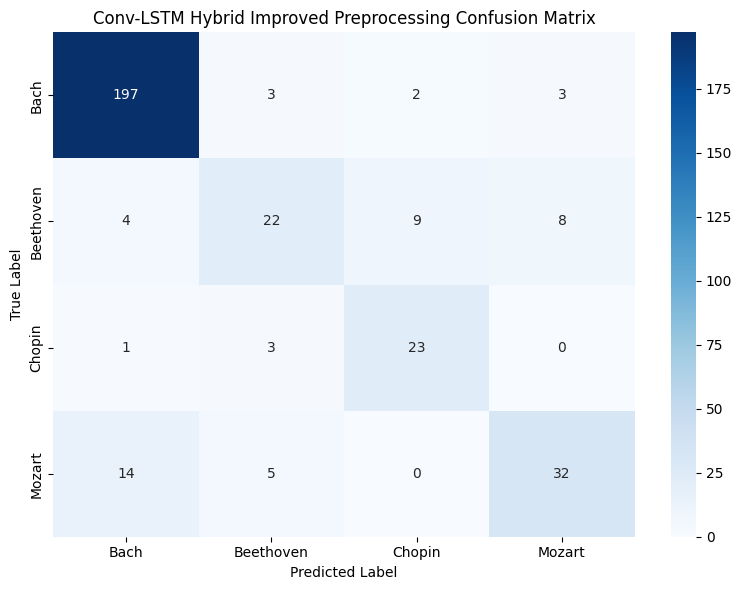

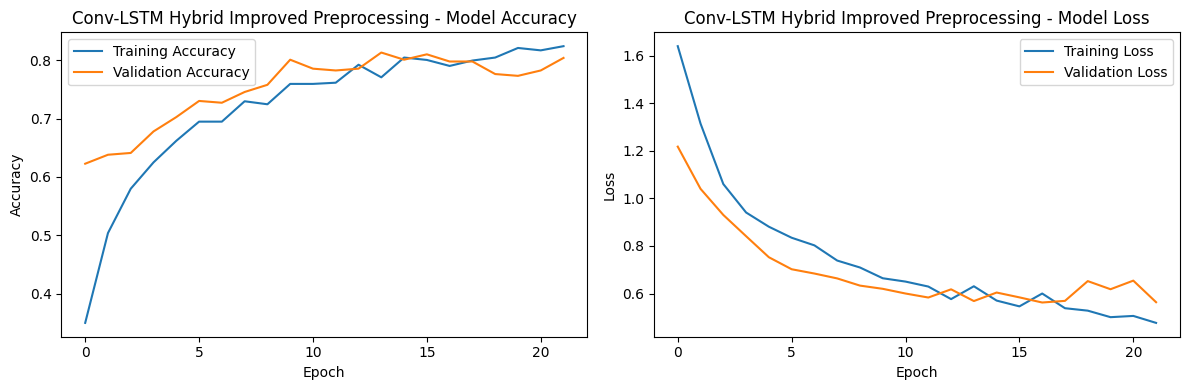

In [ ]:
input_shape = X_train_improved.shape[1:]
num_classes = len(composer_names)

conv_lstm_improved_preprocessing = create_conv_lstm_model(input_shape, num_classes)
models['conv_lstm_improved_preprocessing'] = train_and_evaluate_model(
    conv_lstm_improved_preprocessing, "Conv-LSTM Hybrid Improved Preprocessing", 
    X_train_improved, y_train, X_val_improved, y_val, X_test_improved, y_test
)

Model Optimization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import json
import os
import pickle

2025-08-09 13:12:56.305693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-09 13:12:56.305775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-09 13:12:56.354484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-09 13:12:56.451123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-09 13:12:57.462616: W tensorflow/compiler/tf2

In [3]:
# Load processed data to avoid re-running the data processing pipeline
data_dir = 'processed_data'
if not os.path.exists(data_dir):
    print("Processed data not found. Running data processing first...")
    import subprocess
    subprocess.run(['python', 'data_processing.py'])

# Load the processed data
print("Loading processed data...")

# Load numpy arrays
X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

# Load metadata
with open(os.path.join(data_dir, 'data_metadata.json'), 'r') as f:
    metadata = json.load(f)

# Load complete dataset for additional info
complete_data_file = os.path.join(data_dir, 'composer_classification_data.pkl')
if os.path.exists(complete_data_file):
    with open(complete_data_file, 'rb') as f:
        complete_data = pickle.load(f)
    composer_names = complete_data.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])
else:
    composer_names = metadata.get('composer_names', ['Bach', 'Beethoven', 'Chopin', 'Mozart'])

print(f"Data loaded successfully!")
print(f"Composers: {composer_names}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

Loading processed data...
Data loaded successfully!
Composers: ['Bach' 'Beethoven' 'Chopin' 'Mozart']
X_train shape: (976, 128, 1000)
X_val shape: (326, 128, 1000)
X_test shape: (326, 128, 1000)
y_train shape: (976,)
y_val shape: (326,)
y_test shape: (326,)


In [4]:
# Prepare data for RNN (transpose for time series)
# From (samples, 128, time_steps) to (samples, time_steps, 128)
X_train_rnn = np.transpose(X_train, (0, 2, 1))
X_val_rnn = np.transpose(X_val, (0, 2, 1))
X_test_rnn = np.transpose(X_test, (0, 2, 1))

print("Data prepared for RNN:")
print(f"X_train_rnn shape: {X_train_rnn.shape}")
print(f"X_val_rnn shape: {X_val_rnn.shape}")
print(f"X_test_rnn shape: {X_test_rnn.shape}")

# Create data dictionary for easy access
rnn_data = {
    'X_train': X_train_rnn,
    'X_val': X_val_rnn,
    'X_test': X_test_rnn,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'composer_names': composer_names
}

Data prepared for RNN:
X_train_rnn shape: (976, 1000, 128)
X_val_rnn shape: (326, 1000, 128)
X_test_rnn shape: (326, 1000, 128)


In [5]:
def improved_preprocessing(X_data):
    """
    Improved data preprocessing
    """
    # 1. Normalize velocity values
    X_normalized = X_data / 127.0
    
    # 2. Apply log scaling to reduce dynamic range
    X_log = np.log1p(X_normalized * 10)
    
    # 3. Apply frequency domain features
    X_fft = np.abs(np.fft.fft(X_log, axis=1))
    
    # 4. Combine time and frequency features
    X_combined = np.concatenate([X_log, X_fft[:, :X_log.shape[1]]], axis=2)
    
    return X_combined

X_train_improved = improved_preprocessing(X_train_rnn)
X_val_improved = improved_preprocessing(X_val_rnn)
X_test_improved = improved_preprocessing(X_test_rnn)

In [6]:
input_shape = X_train_improved.shape[1:]
num_classes = len(composer_names)

In [7]:
def create_conv_lstm_tunable(hp):
    """
    Tunable version of your Conv-LSTM Hybrid model
    """
    # Hyperparameters to tune
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    conv_filters = hp.Int('conv_filters', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    # Your Conv-LSTM architecture with tunable parameters
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),
        
        # Reshape for 1D convolution
        layers.Reshape((input_shape[0], input_shape[1])),
        
        # 1D Convolutional layers (tunable filters)
        layers.Conv1D(conv_filters, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        
        layers.Conv1D(conv_filters*2, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        
        # LSTM layers (tunable units)
        layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        layers.BatchNormalization(),
        
        layers.LSTM(lstm_units//2, return_sequences=False, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        layers.BatchNormalization(),
        
        # Dense layers (tunable units)
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        
        layers.Dense(dense_units//2, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile with tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
def advanced_grid_search():
    """
    Advanced grid search focusing on different parameters
    """
    print("Advanced grid search with different focus...")
    
    # Focus on architectural parameters that matter more
    param_combinations = [
        # (lstm_units, conv_filters, dropout_rate, learning_rate, optimizer, activation)
        (64, 64, 0.2, 0.001, 'adam', 'relu'),
        (128, 64, 0.2, 0.001, 'adam', 'relu'),
        (64, 128, 0.2, 0.001, 'adam', 'relu'),
        (128, 128, 0.2, 0.001, 'adam', 'relu'),
        (64, 64, 0.3, 0.001, 'adam', 'relu'),
        (64, 64, 0.2, 0.0005, 'adam', 'relu'),
        (64, 64, 0.2, 0.001, 'adam', 'elu'),
        (64, 64, 0.2, 0.001, 'rmsprop', 'relu'),
        (64, 64, 0.2, 0.001, 'adam', 'relu'),
        (32, 32, 0.1, 0.001, 'adam', 'relu'),  # Smaller model
        (256, 256, 0.4, 0.001, 'adam', 'relu'),  # Larger model
    ]
    
    best_score = 0
    best_params = None
    results = []
    
    for i, (lstm_units, conv_filters, dropout_rate, learning_rate, optimizer_name, activation) in enumerate(param_combinations):
        print(f"\nTrial {i+1}: LSTM={lstm_units}, Conv={conv_filters}, Dropout={dropout_rate}, LR={learning_rate}, Opt={optimizer_name}, Act={activation}")
        
        # Create model with different optimizers and activations
        model = keras.Sequential([
            layers.Input(shape=input_shape),
            layers.BatchNormalization(),
            
            layers.Reshape((input_shape[0], input_shape[1])),
            
            layers.Conv1D(conv_filters, 3, activation=activation, padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2),
            
            layers.Conv1D(conv_filters*2, 3, activation=activation, padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2),
            
            layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
            layers.BatchNormalization(),
            
            layers.LSTM(lstm_units//2, return_sequences=False, dropout=dropout_rate, recurrent_dropout=dropout_rate),
            layers.BatchNormalization(),
            
            layers.Dense(128, activation=activation),
            layers.Dropout(dropout_rate),
            layers.BatchNormalization(),
            
            layers.Dense(64, activation=activation),
            layers.Dropout(dropout_rate),
            layers.BatchNormalization(),
            
            layers.Dense(num_classes, activation='softmax')
        ])
        
        # Choose optimizer
        if optimizer_name == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=0
        )
        
        history = model.fit(
            X_train_improved, y_train,
            validation_data=(X_val_improved, y_val),
            epochs=25,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0
        )
        
        val_accuracy = max(history.history['val_accuracy'])
        results.append({
            'trial': i+1,
            'params': (lstm_units, conv_filters, dropout_rate, learning_rate, optimizer_name, activation),
            'val_accuracy': val_accuracy
        })
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = (lstm_units, conv_filters, dropout_rate, learning_rate, optimizer_name, activation)
            print(f"✓ NEW BEST! {val_accuracy:.4f}")
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best validation accuracy: {best_score:.4f}")
    
    return best_params, results

# Run advanced grid search
best_params, results = advanced_grid_search()

Advanced grid search with different focus...

Trial 1: LSTM=64, Conv=64, Dropout=0.2, LR=0.001, Opt=adam, Act=relu


2025-08-09 13:13:29.581607: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 999424000 exceeds 10% of free system memory.
2025-08-09 13:13:44.104005: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 333824000 exceeds 10% of free system memory.


Validation Accuracy: 0.8344
✓ NEW BEST! 0.8344

Trial 2: LSTM=128, Conv=64, Dropout=0.2, LR=0.001, Opt=adam, Act=relu


2025-08-09 13:17:08.573322: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 999424000 exceeds 10% of free system memory.
2025-08-09 13:17:26.618430: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 333824000 exceeds 10% of free system memory.


Validation Accuracy: 0.8098

Trial 3: LSTM=64, Conv=128, Dropout=0.2, LR=0.001, Opt=adam, Act=relu


2025-08-09 13:21:48.705736: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 999424000 exceeds 10% of free system memory.


Validation Accuracy: 0.8129

Trial 4: LSTM=128, Conv=128, Dropout=0.2, LR=0.001, Opt=adam, Act=relu
Validation Accuracy: 0.8129

Trial 5: LSTM=64, Conv=64, Dropout=0.3, LR=0.001, Opt=adam, Act=relu
Validation Accuracy: 0.8037

Trial 6: LSTM=64, Conv=64, Dropout=0.2, LR=0.0005, Opt=adam, Act=relu
Validation Accuracy: 0.8037

Trial 7: LSTM=64, Conv=64, Dropout=0.2, LR=0.001, Opt=adam, Act=elu
Validation Accuracy: 0.8313

Trial 8: LSTM=64, Conv=64, Dropout=0.2, LR=0.001, Opt=rmsprop, Act=relu
Validation Accuracy: 0.8313

Trial 9: LSTM=64, Conv=64, Dropout=0.2, LR=0.001, Opt=adam, Act=relu
Validation Accuracy: 0.8160

Trial 10: LSTM=32, Conv=32, Dropout=0.1, LR=0.001, Opt=adam, Act=relu
Validation Accuracy: 0.8037

Trial 11: LSTM=256, Conv=256, Dropout=0.4, LR=0.001, Opt=adam, Act=relu
Validation Accuracy: 0.8313

Best parameters: (64, 64, 0.2, 0.001, 'adam', 'relu')
Best validation accuracy: 0.8344
